In [1]:
import numpy as np
import scipy.io

# random seed.
rand_seed = 2

from numpy.random import seed
seed(rand_seed)
from tensorflow import set_random_seed
set_random_seed(rand_seed)

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten, Activation
from keras.layers.core import Permute, Reshape
from keras import backend as K

Using TensorFlow backend.


In [2]:
def one_hot_encoding(y_data):
    Mapping=dict()
    sub_dirs=['downstair','upstair','run','jump','walk','handwashing','exercise']

    categories=10

    count=0
    for i in sub_dirs:
        Mapping[i]=count
        count=count+1

    y_features2=[]
    for i in range(len(y_data)):
        Type=y_data[i]
        lab=Mapping[Type]
        y_features2.append(lab)

    y_features=np.array(y_features2)
    y_features=y_features.reshape(y_features.shape[0],1)
    from keras.utils import to_categorical
    y_features = to_categorical(y_features)

    return y_features

In [3]:
path='ADD_PATH_To_Data'


def get_train_data(path=path):
    Train_data=np.load(path+'train_5000.npz')
    Features_imu=Train_data['arr_0']
    Labels=Train_data['arr_1']
    Features_sound=Train_data['arr_2']

    Labels = one_hot_encoding(Labels)
    Features_imu = Features_imu.reshape(Features_imu.shape[0],1, Features_imu.shape[1], Features_imu.shape[2]) 

    return Features_imu,Labels,Features_sound

def get_valid_data(path=path):
    Train_data=np.load(path+'valid_1000.npz')
    Features_imu=Train_data['arr_0']
    Labels=Train_data['arr_1']
    Features_sound=Train_data['arr_2']

    Labels = one_hot_encoding(Labels)
    Features_imu = Features_imu.reshape(Features_imu.shape[0],1, Features_imu.shape[1], Features_imu.shape[2]) 

    return Features_imu,Labels,Features_sound

def get_test_data(path=path):
    Train_data=np.load(path+'test_1377.npz')
    Features_imu=Train_data['arr_0']
    Labels=Train_data['arr_1']
    Features_sound=Train_data['arr_2']

    Labels = one_hot_encoding(Labels)
    Features_imu = Features_imu.reshape(Features_imu.shape[0],1, Features_imu.shape[1], Features_imu.shape[2]) 

    return Features_imu,Labels,Features_sound

In [4]:
Features_imu,Labels,Features_sound = get_train_data()
print(Features_imu.shape, Labels.shape, Features_sound.shape)
print('Train Classes distribution: ',np.sum(Labels, axis =0))

Features_imu2,Labels2,Features_sound2 = get_valid_data()
print(Features_imu2.shape, Labels2.shape, Features_sound2.shape)
print('Valid Classes distribution: ',np.sum(Labels2, axis =0))

Features_imu3,Labels3,Features_sound3 = get_test_data()
print(Features_imu3.shape, Labels3.shape, Features_sound3.shape)
print('Test Classes distribution: ',np.sum(Labels3, axis =0))



(5000, 1, 40, 12) (5000, 7) (5000, 193)
Train Classes distribution:  [760. 994. 546. 780. 532. 732. 656.]
(1000, 1, 40, 12) (1000, 7) (1000, 193)
Valid Classes distribution:  [150. 188. 136. 141.  98. 157. 130.]
(1377, 1, 40, 12) (1377, 7) (1377, 193)
Test Classes distribution:  [219. 268. 124. 146. 143. 234. 243.]


# IMU Model

In [6]:
# With dropout in the network

num_feat_map = 32

_, dim, win_len, _, = Features_imu.shape
num_classes=7


def full_imu_model():  
    print('building the model ... ')        
    model = Sequential()
    model.add(Conv2D(num_feat_map, kernel_size=(1, 5),
                 activation='relu',
                  input_shape=(dim, win_len, 12),
                 padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Conv2D(num_feat_map, kernel_size=(1, 5), activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Flatten())
    model.add(Dense(256, name='DENSE_3'))
    model.add(Activation('relu', name = 'ACT_3'))
    model.add(Dropout(0.3))
    model.add(Dense(128, name='DENSE_2'))
    model.add(Activation('relu', name = 'ACT_2'))
    model.add(Dense(64, name='DENSE_1'))
    model.add(Activation('relu', name = 'ACT_1'))

    model.add(Dense(num_classes, activation='softmax', name = 'OUTPUT'))
    
    return model

In [7]:
IMU_model = full_imu_model()

building the model ... 


In [8]:
IMU_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 40, 32)         1952      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 20, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 20, 32)         5152      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 10, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
DENSE_3 (Dense)              (None, 256)               82176     
_________________________________________________________________
ACT_3 (Activation)           (None, 256)               0         
__________

In [9]:
model_path = '/home/nesl/Sandeep/Trained_models/IMU_Example'


from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath=model_path, verbose=1,monitor='val_acc' ,save_best_only=True, save_weights_only=False)

In [10]:
batch_size = 128
epochs = 50
from keras import optimizers
from keras.optimizers import Adam

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
IMU_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer= adam,
              metrics=['accuracy'])

import time
start_time = time.time()

learning_hist = IMU_model.fit(Features_imu, Labels,
                    verbose=1,
                    epochs=epochs,
                        shuffle=True,
                    batch_size=batch_size,
                        callbacks=[checkpointer],
                    validation_data=(Features_imu2, Labels2))

end_time = time.time()

print("---Time %s seconds ---" % (end_time - start_time))

Train on 5000 samples, validate on 1000 samples
Epoch 1/50
5000/5000 [==============================] - 4s 778us/step - loss: 7.1730 - acc: 0.2948 - val_loss: 1.7285 - val_acc: 0.5480

Epoch 00001: val_acc improved from -inf to 0.54800, saving model to /home/nesl/Sandeep/Trained_models/IMU_Example
Epoch 2/50
5000/5000 [==============================] - 2s 367us/step - loss: 1.4818 - acc: 0.5706 - val_loss: 0.9326 - val_acc: 0.6940

Epoch 00002: val_acc improved from 0.54800 to 0.69400, saving model to /home/nesl/Sandeep/Trained_models/IMU_Example
Epoch 3/50
5000/5000 [==============================] - 2s 369us/step - loss: 0.8863 - acc: 0.7014 - val_loss: 0.6737 - val_acc: 0.7660

Epoch 00003: val_acc improved from 0.69400 to 0.76600, saving model to /home/nesl/Sandeep/Trained_models/IMU_Example
Epoch 4/50
5000/5000 [==============================] - 2s 377us/step - loss: 0.7075 - acc: 0.7600 - val_loss: 0.5527 - val_acc: 0.8260

Epoch 00004: val_acc improved from 0.76600 to 0.82600, s

5000/5000 [==============================] - 2s 371us/step - loss: 0.0446 - acc: 0.9862 - val_loss: 0.3315 - val_acc: 0.9360

Epoch 00037: val_acc did not improve from 0.94500
Epoch 38/50
5000/5000 [==============================] - 2s 371us/step - loss: 0.0467 - acc: 0.9880 - val_loss: 0.3178 - val_acc: 0.9400

Epoch 00038: val_acc did not improve from 0.94500
Epoch 39/50
5000/5000 [==============================] - 2s 371us/step - loss: 0.0410 - acc: 0.9884 - val_loss: 0.3011 - val_acc: 0.9440

Epoch 00039: val_acc did not improve from 0.94500
Epoch 40/50
5000/5000 [==============================] - 2s 377us/step - loss: 0.0306 - acc: 0.9914 - val_loss: 0.3132 - val_acc: 0.9500

Epoch 00040: val_acc improved from 0.94500 to 0.95000, saving model to /home/nesl/Sandeep/Trained_models/IMU_Example
Epoch 41/50
5000/5000 [==============================] - 2s 376us/step - loss: 0.0297 - acc: 0.9932 - val_loss: 0.3043 - val_acc: 0.9430

Epoch 00041: val_acc did not improve from 0.95000
Epoch

In [11]:
from keras.models import load_model

IMU_model = load_model(model_path)

In [12]:
#Train Accuracy
IMU_model.evaluate(Features_imu,Labels)

5000/5000 [==============================] - 2s 374us/step


[0.009534283232755843, 0.9982]

In [13]:
#valid Accuracy
IMU_model.evaluate(Features_imu2,Labels2)

1000/1000 [==============================] - 0s 359us/step


[0.31315830117464066, 0.95]

In [14]:
#Test Accuracy
IMU_model.evaluate(Features_imu3,Labels3)

1377/1377 [==============================] - 1s 371us/step


[0.41778624388540914, 0.90559186637618]

# Plotting

dict_keys(['val_loss', 'val_acc', 'acc', 'loss'])


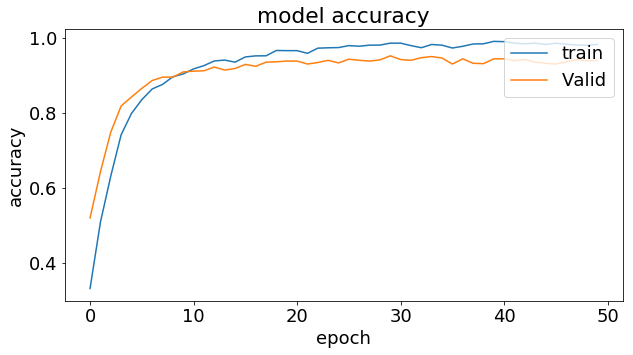

In [44]:
from matplotlib import pyplot as plt

print(learning_hist.history.keys())
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(10,5))

plt.plot(learning_hist.history['acc'])
plt.plot(learning_hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Valid'], loc='upper right')
plt.show()

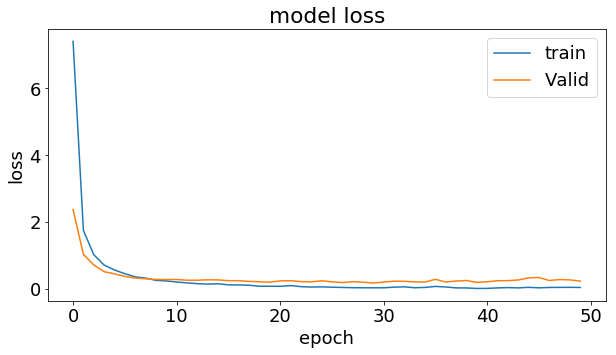

In [45]:
# summarize history for loss

from matplotlib import pyplot as plt

plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 18})


plt.plot(learning_hist.history['loss'])
plt.plot(learning_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Valid'], loc='upper right')
plt.show()